# Simulación de un sistema de colas con servidores paralelos
# (Ejemplo 7.4 del libro "Simulation, Fifth Edition by Sheldon M. Ross")

Este archivo implementa una simulación de eventos discretos para un sistema de colas con las siguientes características:

- Los clientes llegan al sistema de acuerdo con una distribución de tiempos entre llegadas.
- El sistema cuenta con varios servidores paralelos.
- Cuando un cliente llega:
  - Si todos los servidores están ocupados, el cliente entra en una cola FIFO (primero en llegar, primero en ser atendido)
  - Si algún servidor está libre, el cliente entra directamente a servicio con el primer servidor que esté libre según el orden de servidores
- Cuando un servidor termina de atender la solicitud de un cliente:
  - El cliente abandona el sistema.
  - Si hay clientes en cola, el siguiente en orden entra al servidor que se ha liberado.
- Cada servidor tiene su propia distribución de tiempos de servicio.
- Se realiza un seguimiento del:
  - Tiempo total en el sistema de cada cliente
  - Porciento de servicios completados por cada servidor respecto al total.

La simulación está basada en el paradigma de simulación de eventos discretos, manteniendo una lista de eventos con los siguientes tipos:
- `arrival`: llegada de un nuevo cliente.
- `departure`: finalización de servicio en el servidor especificado en el evento.

Esta simulación permite estudiar el comportamiento del sistema bajo distintas distribuciones de llegada y servicio, y analizar métricas como tiempo promedio en el sistema, carga de los servidores, y longitud promedio de la cola.


In [113]:
# Importar librerías a utilizar
import heapq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [114]:
# --- Evento ---
class Event:
    def __init__(self, time, e_type, client_id, server_id=None):
        self.time = time
        self.type = e_type  # 'arrival', 'departure'
        self.server_id = server_id
        self.client_id = client_id

    def __lt__(self, other):
        return self.time < other.time  # Sobrecarga de operador '<' para indicar a python como comparar dos eventos usando el tiempo

# --- Simulador ---
def simulate_queueing_system(servers_ammount, arrival_rate, service_time_rates, time_limit):
    actual_time = 0                             # tiempo actual
    event_list = []                             # lista de eventos (heapq)
    queue = []                                  # cola de espera
    servers = [None] * servers_ammount          # cada servidor es inicializado vacío
    standby_times = []                          # tiempo que cada cliente esperó antes de ser procesada
    system_times = []                           # tiempos totales en el sistema
    processing_time = [0] * servers_ammount     # tiempo acumulado de procesamiento para cada servidor
    server_served_count = [0] * servers_ammount # cantidad de clientes atendidos por cada servidor
    last_time = 0                               # último tiempo registrado en el sistema
    client_counter = 1
    client_arrival_times = {}
    client_departure_times = {}
    rng = np.random.default_rng()               # generador de numeros random

    # insertando la primera llegada al sistema de una solicitud
    heapq.heappush(event_list, Event(rng.exponential(1/arrival_rate), 'arrival', client_counter))
    client_counter = client_counter+1

    # empezando a procesar los eventos del sistema
    while event_list:
        event = heapq.heappop(event_list)   # procesando el evento que corresponde
        actual_time = event.time            # actualizando tiempo del evento
        # si no pasamos del límite de tiempo, detén el bucle
        if actual_time > time_limit:
            break
        # actualizando tiempo de procesamiento de servidores ocupados
        for i in range(servers_ammount):
            if servers[i] is not None:
                processing_time[i] = processing_time[i] + (actual_time-last_time)
        last_time = actual_time # actualizando tiempo anterior

        # verificando caso del evento de llegada
        if event.type == 'arrival':
            # agregando tiempo a la entrada
            client_arrival_times[event.client_id] = actual_time
            # detectando si hay servidores libres
            free_server = None
            for i in range(servers_ammount):
                if servers[i] is None:
                    free_server = i
                    break
            # si existe algún servidor libre, agrega la solicitud a ese servidor
            if free_server is not None:
                service_time = rng.exponential(1/service_time_rates[free_server])       # genera tiempo de procesamiento aleatorio
                departure = actual_time + service_time                                  # calcula el tiempo de salida
                servers[free_server] = departure                                        # agrega el tiempo de salida calculado al servidor
                heapq.heappush(event_list, Event(departure, 'departure', event.client_id, free_server))  # agrega el evento de salida a la lista de eventos
                standby_times.append(0)                                                 # agrega 0 como tiempo de espera de la solicitud
                system_times.append(service_time)                                       # solo servicio, sin espera
                server_served_count[free_server] += 1                                   # registra atención del servidor
            # si no existe ningún servidor libre, agrega la solicitud del cliente a la cola
            else:
                queue.append((event.client_id, actual_time)) # guardar tiempo de llegada en la cola
            next_arrival = actual_time + rng.exponential(1/arrival_rate)
            heapq.heappush(event_list, Event(next_arrival, 'arrival', client_counter))
            client_counter = client_counter+1
            

        # verificando caso del evento de salida
        elif event.type == 'departure':
            # si el evento es una salida, finaliza el proceso en el procesador
            servers[event.server_id] = None
            client_departure_times[event.client_id] = event.time
            # si hay solicitudes en cola, que entre la siguiente al procesador liberado
            if queue:
                client_id, client_arrival = queue.pop(0)
                waiting_time = actual_time - client_arrival
                standby_times.append(waiting_time)
                service_time = rng.exponential(1/service_time_rates[event.server_id])
                departure = actual_time + service_time
                servers[event.server_id] = departure
                heapq.heappush(event_list, Event(departure, 'departure', client_id ,event.server_id))
                system_times.append(waiting_time + service_time)  # total en sistema
                server_served_count[event.server_id] += 1          # registra atención del servidor

    # Calculando tiempo de espera y tiempo total en el sistema para cada cliente
    if standby_times:
        average_standby_time = sum(standby_times) / len(standby_times) 
    else:
        average_standby_time = 0

    if system_times:
        average_system_times = sum(system_times) / len(system_times)
    else:
        average_system_times = 0

    # Cálculo de porcentaje de atenciones por servidor
    total_served = sum(server_served_count)
    if total_served > 0:
        server_percentages = [count / total_served * 100 for count in server_served_count]
    else:
        server_percentages = [0] * servers_ammount

    return average_system_times, average_standby_time, processing_time, server_percentages, client_arrival_times, client_departure_times, server_served_count

**TEST 1:** El siguiente experimento tiene como objetivo analizar cómo afecta la cantidad de servidores al tiempo promedio de espera de los clientes en un sistema de colas con llegadas Poisson y tiempos de servicio exponenciales.

Se simulan tres configuraciones distintas:
- 2 servidores
- 3 servidores
- 5 servidores

El resto de parámetros se mantiene constante:
- Tasa de llegada: 0.25 clientes por unidad de tiempo
- Tasa de servicio por servidor: 1 cliente por unidad de tiempo
- Tiempo total simulado: 300 unidades de tiempo
- Número de simulaciones por configuración: 20

El resultado se representa en un gráfico que muestra la evolución del tiempo de espera promedio a lo largo de las 20 simulaciones para cada configuración. Esto permite observar la tendencia de reducción en el tiempo de espera a medida que se incrementa el número de servidores disponibles.

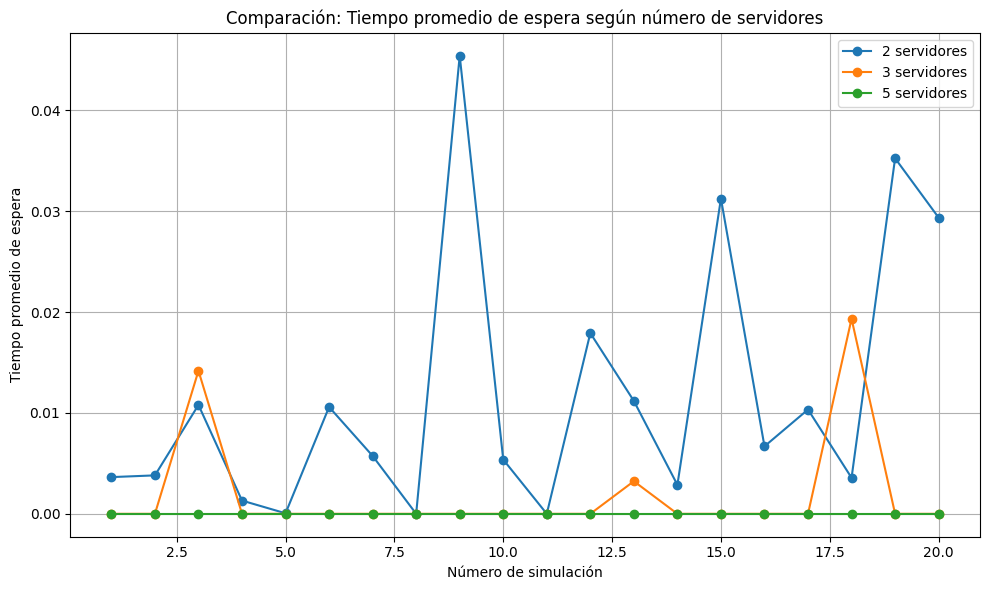

In [115]:
# --- TEST 1: Comparación entre tiempos de espera con variación en la cantidad de servidores ---

# Parámetros comunes
arrival_rate = 1/4
service_rate = 1
time_limit = 300
simulation_ammount = 20
server_configs = [2, 3, 5]

# Almacenar resultados
wait_time_results = {}

# Ejecutar simulaciones
for n_servers in server_configs:
    rng = np.random.default_rng()
    wait_times = []
    for _ in range(simulation_ammount):
        service_rates = [service_rate] * n_servers
        _, avg_wait, _, _, _, _, _ = simulate_queueing_system(n_servers, arrival_rate, service_rates, time_limit)
        wait_times.append(avg_wait)
    wait_time_results[f'{n_servers} servidores'] = wait_times


# Graficar tiempos de espera y en el sistema
plt.figure(figsize=(10, 6))

for label, values in wait_time_results.items():
    plt.plot(range(1, simulation_ammount + 1), values, marker='o', linestyle='-', label=label)

plt.title('Comparación: Tiempo promedio de espera según número de servidores')
plt.xlabel('Número de simulación')
plt.ylabel('Tiempo promedio de espera')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**TEST 2:** Este experimento analiza cómo se distribuye la carga de atención entre dos servidores con tasas de servicio diferentes. Se comparan dos configuraciones: una en la que un servidor atiende al doble de velocidad que el otro, y otra en la que ambos servidores tienen la misma tasa. El objetivo es observar si el sistema asigna más tareas al servidor más rápido, y en qué medida lo hace

Tasas diferentes [8, 2]:
  Servidor 0: 78.43%
  Servidor 1: 21.57%
Tasas iguales [5, 5]:
  Servidor 0: 58.28%
  Servidor 1: 41.72%


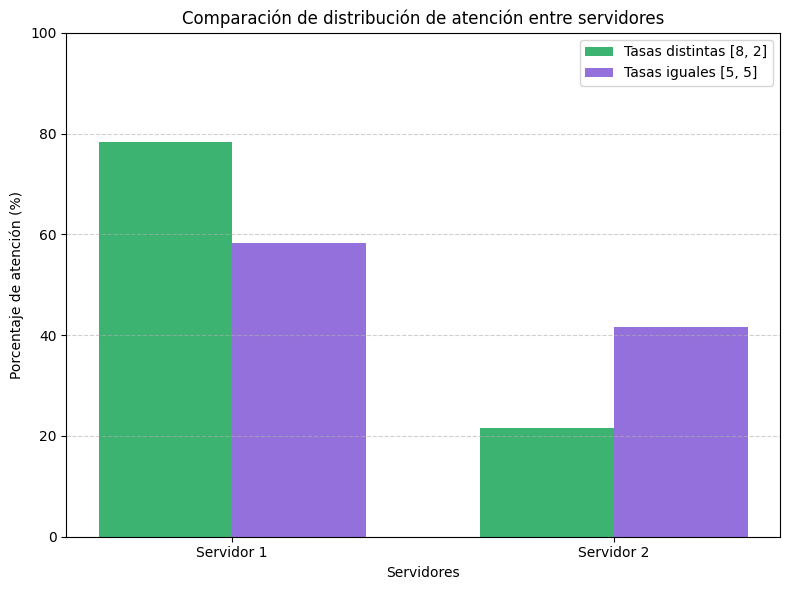

In [116]:
# --- TEST 2: Comparación de porcentaje de atención entre dos servidores con diferente tasa de servicio ---

# --- Configuraciones generales ---
servers = 2
arrival_rate = 5
time_limit = 10000
simulation_runs = 20

# --- Configuración 1: servidores con tasas diferentes ---
service_time_rates_diff = [8, 2]
porcentajes_dif = [[] for _ in range(servers)]

for _ in range(simulation_runs):
    _, _, _, server_percentages, _, _, _ = simulate_queueing_system(
        servers_ammount=servers,
        arrival_rate=arrival_rate,
        service_time_rates=service_time_rates_diff,
        time_limit=time_limit
    )
    for j in range(servers):
        porcentajes_dif[j].append(server_percentages[j])

avg_dif = [sum(p) / simulation_runs for p in porcentajes_dif]

# --- Configuración 2: servidores con tasas iguales ---
service_time_rates_eq = [5, 5]
porcentajes_eq = [[] for _ in range(servers)]

for _ in range(simulation_runs):
    _, _, _, server_percentages, _, _, _ = simulate_queueing_system(
        servers_ammount=servers,
        arrival_rate=arrival_rate,
        service_time_rates=service_time_rates_eq,
        time_limit=time_limit
    )
    for j in range(servers):
        porcentajes_eq[j].append(server_percentages[j])

avg_eq = [sum(p) / simulation_runs for p in porcentajes_eq]

# --- Mostrar resultados por consola ---
print("Tasas diferentes [8, 2]:")
for i, p in enumerate(avg_dif):
    print(f"  Servidor {i}: {p:.2f}%")

print("Tasas iguales [5, 5]:")
for i, p in enumerate(avg_eq):
    print(f"  Servidor {i}: {p:.2f}%")

# --- Gráfico comparativo ---
labels = ['Servidor 1', 'Servidor 2']
x = range(len(labels))
bar_width = 0.35

plt.figure(figsize=(8, 6))
plt.bar(x, avg_dif, width=bar_width, label='Tasas distintas [8, 2]', color='mediumseagreen')
plt.bar([i + bar_width for i in x], avg_eq, width=bar_width, label='Tasas iguales [5, 5]', color='mediumpurple')

plt.xlabel('Servidores')
plt.ylabel('Porcentaje de atención (%)')
plt.title('Comparación de distribución de atención entre servidores')
plt.xticks([i + bar_width / 2 for i in x], labels)
plt.ylim(0, 100)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



Conclusión: Cuando hay diferencia de velocidad entre servidores, el más rápido procesa un mayor porcentaje de solicitudes, lo cual evidencia que el sistema es capaz de aprovechar su mayor capacidad. En la configuración homogénea, la carga se reparte de manera equilibrada.

**TEST 3:** Este test estudia el efecto de variar la tasa de llegada de clientes sobre el rendimiento del sistema. Se realizan simulaciones con tasas de llegada bajas, medias y altas, manteniendo constante la capacidad de atención (tres servidores con tasas iguales). Se mide tanto el tiempo promedio de espera en la cola como el tiempo total que los clientes pasan en el sistema.

Tasa de llegada 3:
  Espera promedio: 0.00
  Tiempo en sistema: 0.20
Tasa de llegada 6:
  Espera promedio: 0.02
  Tiempo en sistema: 0.22
Tasa de llegada 9:
  Espera promedio: 0.06
  Tiempo en sistema: 0.26


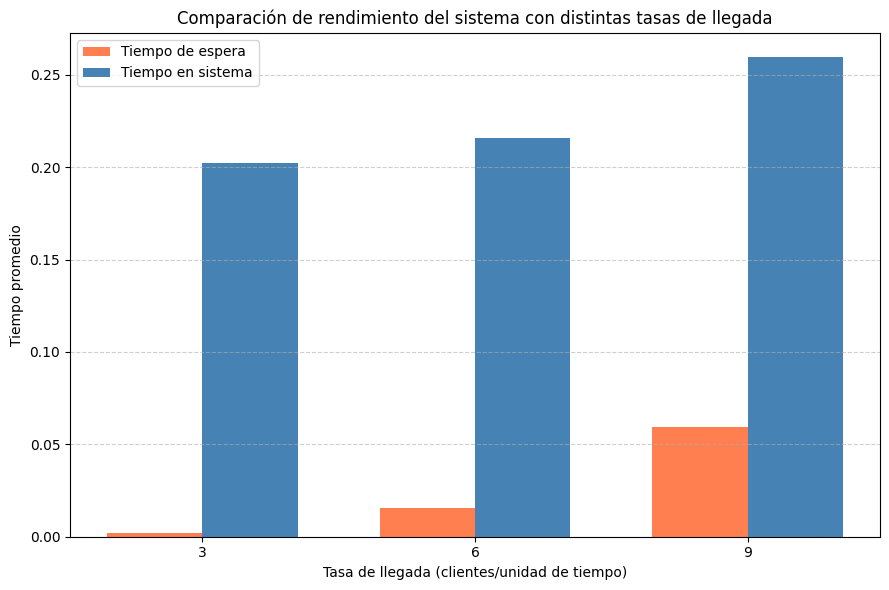

In [117]:
# --- TEST 3: Comparación de duración de tiempos entre tres servidores con diferente tasa de llegada ---

# --- Parámetros base ---
servers = 3
service_time_rates = [5, 5, 5]
time_limit = 10000
arrival_rates = [3, 6, 9]
simulation_runs = 20

# --- Resultados ---
avg_waiting_times = []
avg_system_times = []

for arrival_rate in arrival_rates:
    waiting_times = []
    system_times = []
    
    for _ in range(simulation_runs):
        system_avg, wait_avg, _, _, _, _, _ = simulate_queueing_system(
            servers_ammount=servers,
            arrival_rate=arrival_rate,
            service_time_rates=service_time_rates,
            time_limit=time_limit
        )
        system_times.append(system_avg)
        waiting_times.append(wait_avg)
    
    avg_system_times.append(sum(system_times) / simulation_runs)
    avg_waiting_times.append(sum(waiting_times) / simulation_runs)

# --- Mostrar resultados por consola ---
for i, rate in enumerate(arrival_rates):
    print(f"Tasa de llegada {rate}:")
    print(f"  Espera promedio: {avg_waiting_times[i]:.2f}")
    print(f"  Tiempo en sistema: {avg_system_times[i]:.2f}")

# --- Gráfico ---
x = range(len(arrival_rates))
bar_width = 0.35

plt.figure(figsize=(9, 6))
plt.bar(x, avg_waiting_times, width=bar_width, label='Tiempo de espera', color='coral')
plt.bar([i + bar_width for i in x], avg_system_times, width=bar_width, label='Tiempo en sistema', color='steelblue')

plt.xlabel('Tasa de llegada (clientes/unidad de tiempo)')
plt.ylabel('Tiempo promedio')
plt.title('Comparación de rendimiento del sistema con distintas tasas de llegada')
plt.xticks([i + bar_width / 2 for i in x], [str(r) for r in arrival_rates])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Conclusión: A medida que aumenta la tasa de llegada, el sistema tiende a saturarse. Esto se refleja en un aumento significativo del tiempo de espera, mientras que el tiempo en el sistema también crece debido a las mayores demoras en ser atendido.

**TEST 4:** En este test, se simula un sistema de colas con dos servidores idénticos que atienden una cola con una tasa de llegada baja, lo que representa una situación de baja congestión. El objetivo de este test es comparar el rendimiento de los servidores en términos de su tiempo de atención y la distribución de carga entre ellos en un sistema poco congestionado. Para ello, se ejecutan simulaciones con distintos tiempos de simulación para evaluar cómo los servidores distribuyen la carga de trabajo cuando el sistema está relativamente libre de tráfico. Las tasas de servicio son iguales para ambos servidores, y la tasa de llegada es baja, lo que asegura que los servidores rara vez estén ocupados al mismo tiempo.

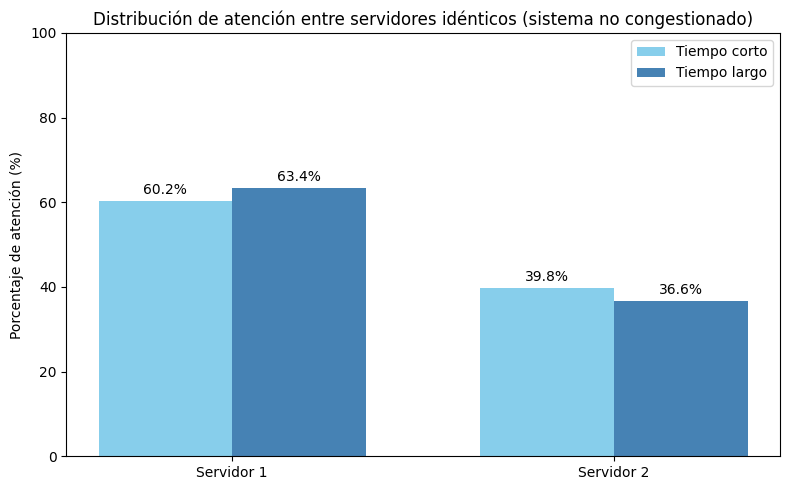

In [118]:
# --- TEST 4: Comparación de equilibrio entre dos servidores iguales - COLA NO CONGESTIONADA ---

# Parámetros comunes
servers_ammount = 2
arrival_rate = 3
service_time_rates = [4, 4]  # servidores idénticos
short_time = 100
long_time = 10000

# Simulación en tiempo corto
_, _, processing_short, percentage_short, _, _, _ = simulate_queueing_system(
    servers_ammount, arrival_rate, service_time_rates, short_time
)

# Simulación en tiempo largo
_, _, processing_long, percentage_long, _, _, _ = simulate_queueing_system(
    servers_ammount, arrival_rate, service_time_rates, long_time
)

# Preparar datos para graficar
labels = ['Servidor 1', 'Servidor 2']
x = range(len(labels))

fig, ax = plt.subplots(figsize=(8, 5))
bar_width = 0.35

bars1 = ax.bar(
    [i - bar_width/2 for i in x], percentage_short, bar_width,
    label='Tiempo corto', color='skyblue'
)
bars2 = ax.bar(
    [i + bar_width/2 for i in x], percentage_long, bar_width,
    label='Tiempo largo', color='steelblue'
)

ax.set_ylabel('Porcentaje de atención (%)')
ax.set_title('Distribución de atención entre servidores idénticos (sistema no congestionado)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 100)
ax.legend()

# Mostrar valores encima de las barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords='offset points',
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()


**TEST 5:** Este test se centra en evaluar el comportamiento de dos servidores idénticos en un entorno altamente congestionado. Aquí, se simula una situación en la que las tasas de llegada son más altas, lo que genera una mayor carga sobre los servidores. Se ejecutan simulaciones con distintos tiempos de simulación para analizar cómo la mayor congestión afecta la distribución de trabajo entre los servidores, el tiempo de espera de los clientes en la cola y el tiempo total en el sistema. Este test permite observar cómo los servidores gestionan la carga de trabajo bajo condiciones de mayor demanda y cómo se reparte el porcentaje de atención entre los servidores a medida que aumentan las llegadas.

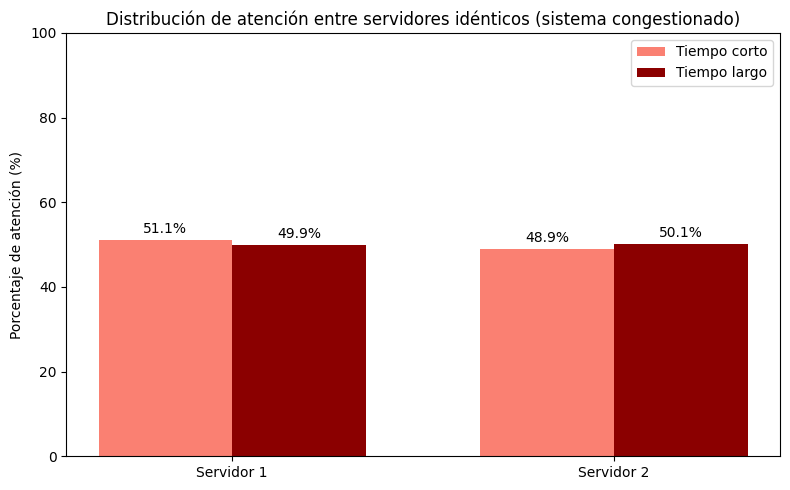

In [119]:
# --- TEST 5: Comparación de equilibrio entre dos servidores iguales - COLA CONGESTIONADA ---

# Parámetros modificados para congestionar el sistema
servers_ammount = 2
arrival_rate = 6              # tasa de llegada más alta → más congestión
service_time_rates = [3, 3]   # servidores un poco más lentos → más uso
short_time = 100
long_time = 10000

# Simulación en tiempo corto
_, _, processing_short, percentage_short, _, _, _ = simulate_queueing_system(
    servers_ammount, arrival_rate, service_time_rates, short_time
)

# Simulación en tiempo largo
_, _, processing_long, percentage_long, _, _, _ = simulate_queueing_system(
    servers_ammount, arrival_rate, service_time_rates, long_time
)

# Preparar datos para graficar
labels = ['Servidor 1', 'Servidor 2']
x = range(len(labels))

fig, ax = plt.subplots(figsize=(8, 5))
bar_width = 0.35

bars1 = ax.bar(
    [i - bar_width/2 for i in x], percentage_short, bar_width,
    label='Tiempo corto', color='salmon'
)
bars2 = ax.bar(
    [i + bar_width/2 for i in x], percentage_long, bar_width,
    label='Tiempo largo', color='darkred'
)

ax.set_ylabel('Porcentaje de atención (%)')
ax.set_title('Distribución de atención entre servidores idénticos (sistema congestionado)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 100)
ax.legend()

# Mostrar valores encima de las barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords='offset points',
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()


**CONCLUSIÓN:** La comparación de los Test 4 y Test 5 revela cómo el comportamiento de los servidores varía en función de la congestión del sistema y el tiempo de simulación. A través de estos tests, se pudo observar cómo la distribución de carga de trabajo entre servidores y el rendimiento del sistema se ven significativamente afectados por el nivel de congestión:

En un sistema no congestionado (Test 4): Cuando la tasa de llegada es baja y los servidores rara vez están ocupados simultáneamente, ambos servidores tienen la capacidad de atender a los clientes casi de manera equitativa. No obstante, el primer servidor tiene la prioridad por encima del segundo, lo cual resulta en una distribución desigual del trabajo total.

En un sistema congestionado (Test 5): A medida que la tasa de llegada aumenta y el sistema se vuelve más congestionado, las solicitudes se acumulan en la cola. Esto provoca que los servidores tengan que trabajar simultáneamente para procesar las solicitudes y en consecuencia la distribución del trabajo es más equitativo debido a que no existen muchos momentos de la simulación en que la cola esté vacía y el primer servidor se pueda hacer cargo solo de cualquier solicitud entrante.

También es importante notar que un corto o largo tiempo de simulación no afectan mucho a la distribución del trabajo por los servidores, pero en el próximo test se analizará si este aspecto tiende a estabilizar o no las medidas de tendencia central.

**TEST 6:** Este test tiene como objetivo evaluar el comportamiento de las medidas de tendencia central de interés para esta simulación (promedio de tiempo en el sistema y promedio de tiempo en espera) respecto a diferentes tiempos de demora de las simulaciones.

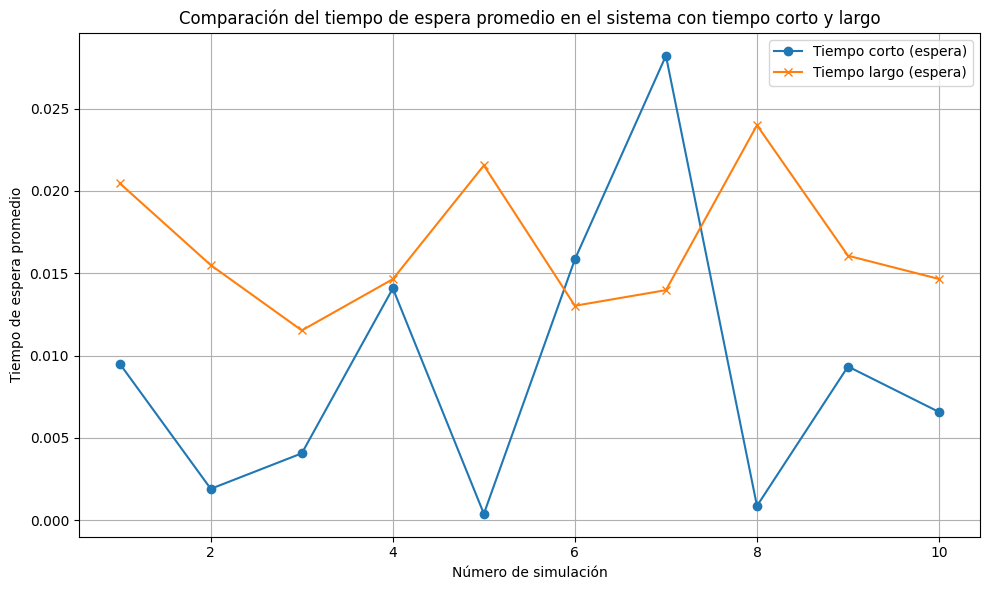

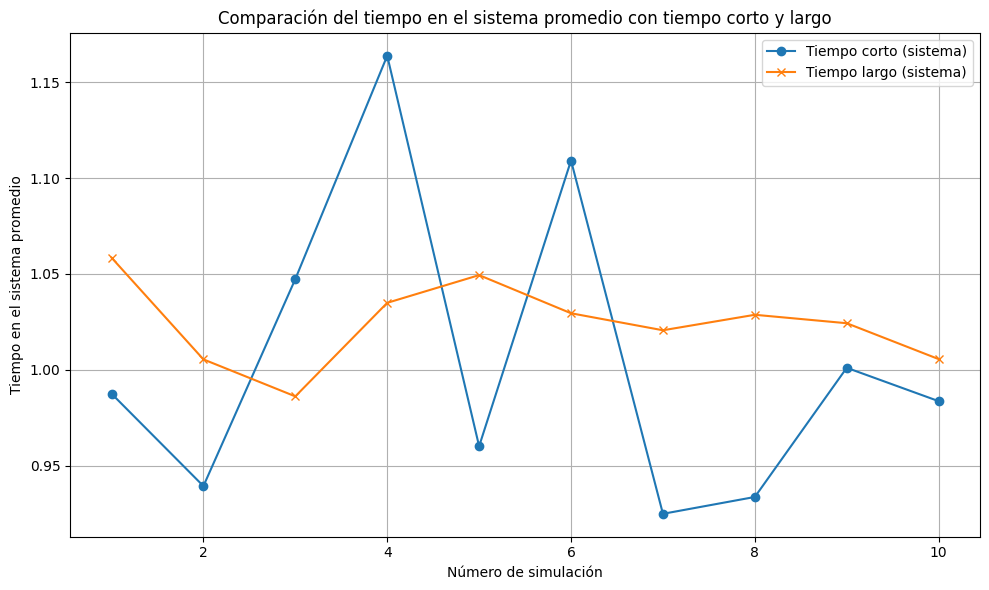

In [120]:
# --- TEST 6: Medidas de tendencia central en diferentes tiempos ---
server_list = 2
service_tr_list = [1, 1]  # Servidores idénticos con la misma tasa de servicio
arrival_rate = 1/4  # Tasa de llegada
time_limit_short = 500   # Tiempo corto
time_limit_long = 10000   # Tiempo largo
simulation_ammount = 10
results_short_waiting = []
results_long_waiting = []
results_short_system = []
results_long_system = []

# Simulación con tiempo corto
for i in range(simulation_ammount):
    avg_system_short, avg_waiting_short, _, _, _, _, _ = simulate_queueing_system(
        server_list,
        arrival_rate,
        service_tr_list,
        time_limit_short
    )
    results_short_waiting.append(avg_waiting_short)
    results_short_system.append(avg_system_short)

# Simulación con tiempo largo
for i in range(simulation_ammount):
    avg_system_long, avg_waiting_long, _, _, _, _, _ = simulate_queueing_system(
        server_list,
        arrival_rate,
        service_tr_list,
        time_limit_long
    )
    results_long_waiting.append(avg_waiting_long)
    results_long_system.append(avg_system_long)

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(range(1, simulation_ammount + 1), results_short_waiting, label='Tiempo corto (espera)', marker='o')
plt.plot(range(1, simulation_ammount + 1), results_long_waiting, label='Tiempo largo (espera)', marker='x')
plt.title('Comparación del tiempo de espera promedio en el sistema con tiempo corto y largo')
plt.xlabel('Número de simulación')
plt.ylabel('Tiempo de espera promedio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, simulation_ammount + 1), results_short_system, label='Tiempo corto (sistema)', marker='o')
plt.plot(range(1, simulation_ammount + 1), results_long_system, label='Tiempo largo (sistema)', marker='x')
plt.title('Comparación del tiempo en el sistema promedio con tiempo corto y largo')
plt.xlabel('Número de simulación')
plt.ylabel('Tiempo en el sistema promedio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**CONCLUSIONES:** Podemos observar que ambas medidas de tendencia central tienden a estabilizarse mientras más tiempo dure la simulación

**TEST 7:** Este test tiene como objetivo evaluar el comportamiento del tiempo de procesamiento de dos servidores iguales con una cola congestionada.

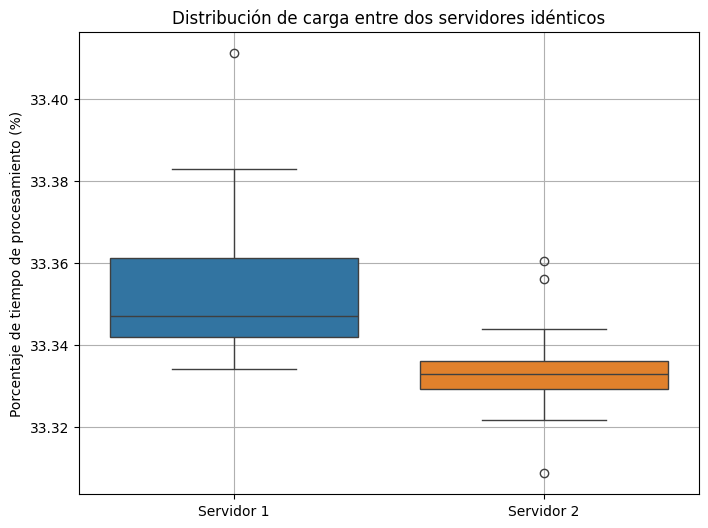

In [121]:
# --- TEST 7: Distribución de la carga entre servidores idénticos ---

# Parámetros de simulación
arrival_rate = 5    # alta tasa de llegada
service_rate = 1    # servidores idénticos
servers_ammount = 3
time_limit = 500
num_simulations = 20

# Recolectar porcentajes de uso
porcentajes_servidor_1 = []
porcentajes_servidor_2 = []

for _ in range(num_simulations):
    _, _, processing_times, _, _, _, _ = simulate_queueing_system(
        servers_ammount,
        arrival_rate,
        [service_rate] * servers_ammount,
        time_limit
    )
    total = sum(processing_times)
    if total > 0:
        porcentajes_servidor_1.append(processing_times[0] / total * 100)
        porcentajes_servidor_2.append(processing_times[1] / total * 100)

# Gráfico boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=[porcentajes_servidor_1, porcentajes_servidor_2])
plt.xticks([0, 1], ["Servidor 1", "Servidor 2"])
plt.ylabel("Porcentaje de tiempo de procesamiento (%)")
plt.title("Distribución de carga entre dos servidores idénticos")
plt.grid(True)
plt.show()


**CONCLUSIONES:** Podemos observar que a pesar de su igualdad de condiciones, la falta de presencia de una mejor estrategia de asignación provoca que un servidor trabaje notablemente más que otro, aunque estos valores no difieren mucho entre sí en una cola congestionada.

**TEST 8:** Este test tiene como objetivo evaluar el comportamiento del tiempo de procesamiento de dos servidores diferentes con una cola congestionada.

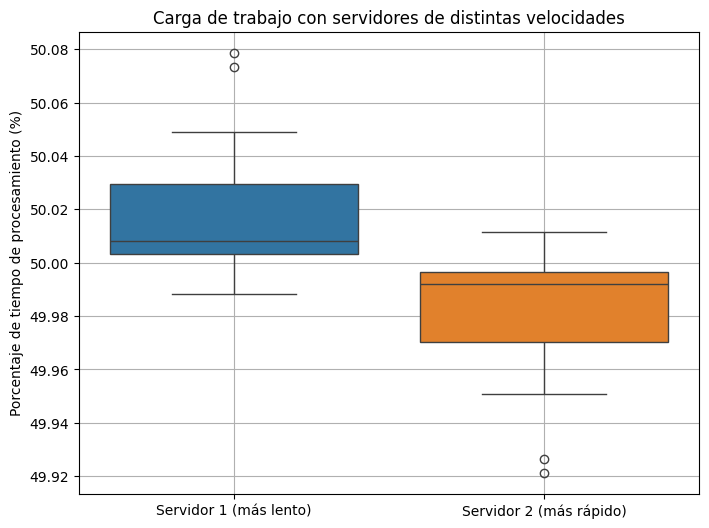

In [122]:
# --- TEST 8: Distribución de la carga entre servidores desiguales ---

# Parámetros de simulación
arrival_rate = 5
service_time_rates = [1, 2]  # el servidor 2 es más rápido
servers_ammount = 2
time_limit = 500
num_simulations = 20

# Recolectar porcentajes de uso
porcentajes_servidor_1 = []
porcentajes_servidor_2 = []

for _ in range(num_simulations):
    _, _, processing_times, _, _, _, _ = simulate_queueing_system(
        servers_ammount,
        arrival_rate,
        service_time_rates,
        time_limit
    )
    total = sum(processing_times)
    if total > 0:
        porcentajes_servidor_1.append(processing_times[0] / total * 100)
        porcentajes_servidor_2.append(processing_times[1] / total * 100)

# Gráfico boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=[porcentajes_servidor_1, porcentajes_servidor_2])
plt.xticks([0, 1], ["Servidor 1 (más lento)", "Servidor 2 (más rápido)"])
plt.ylabel("Porcentaje de tiempo de procesamiento (%)")
plt.title("Carga de trabajo con servidores de distintas velocidades")
plt.grid(True)
plt.show()


**CONCLUSIONES:** Podemos observar que a pesar de su desigualdad de procesamiento, ambos permanecen casi el mismo tiempo procesando debido a la congestión de la cola. Esto no significa que ambos tengan la misma cantidad de procesos realizados, solo significa que llevan casi el mismo tiempo de trabajo, y dado que uno es notablemente más rápido que otro entonces nos lleva a deducir que el más rápido realizó más trabajos.

**TEST 9:** Este test tiene como objetivo evaluar el comportamiento del tiempo de entrada y salida de los clientes en una cola no congestionada.

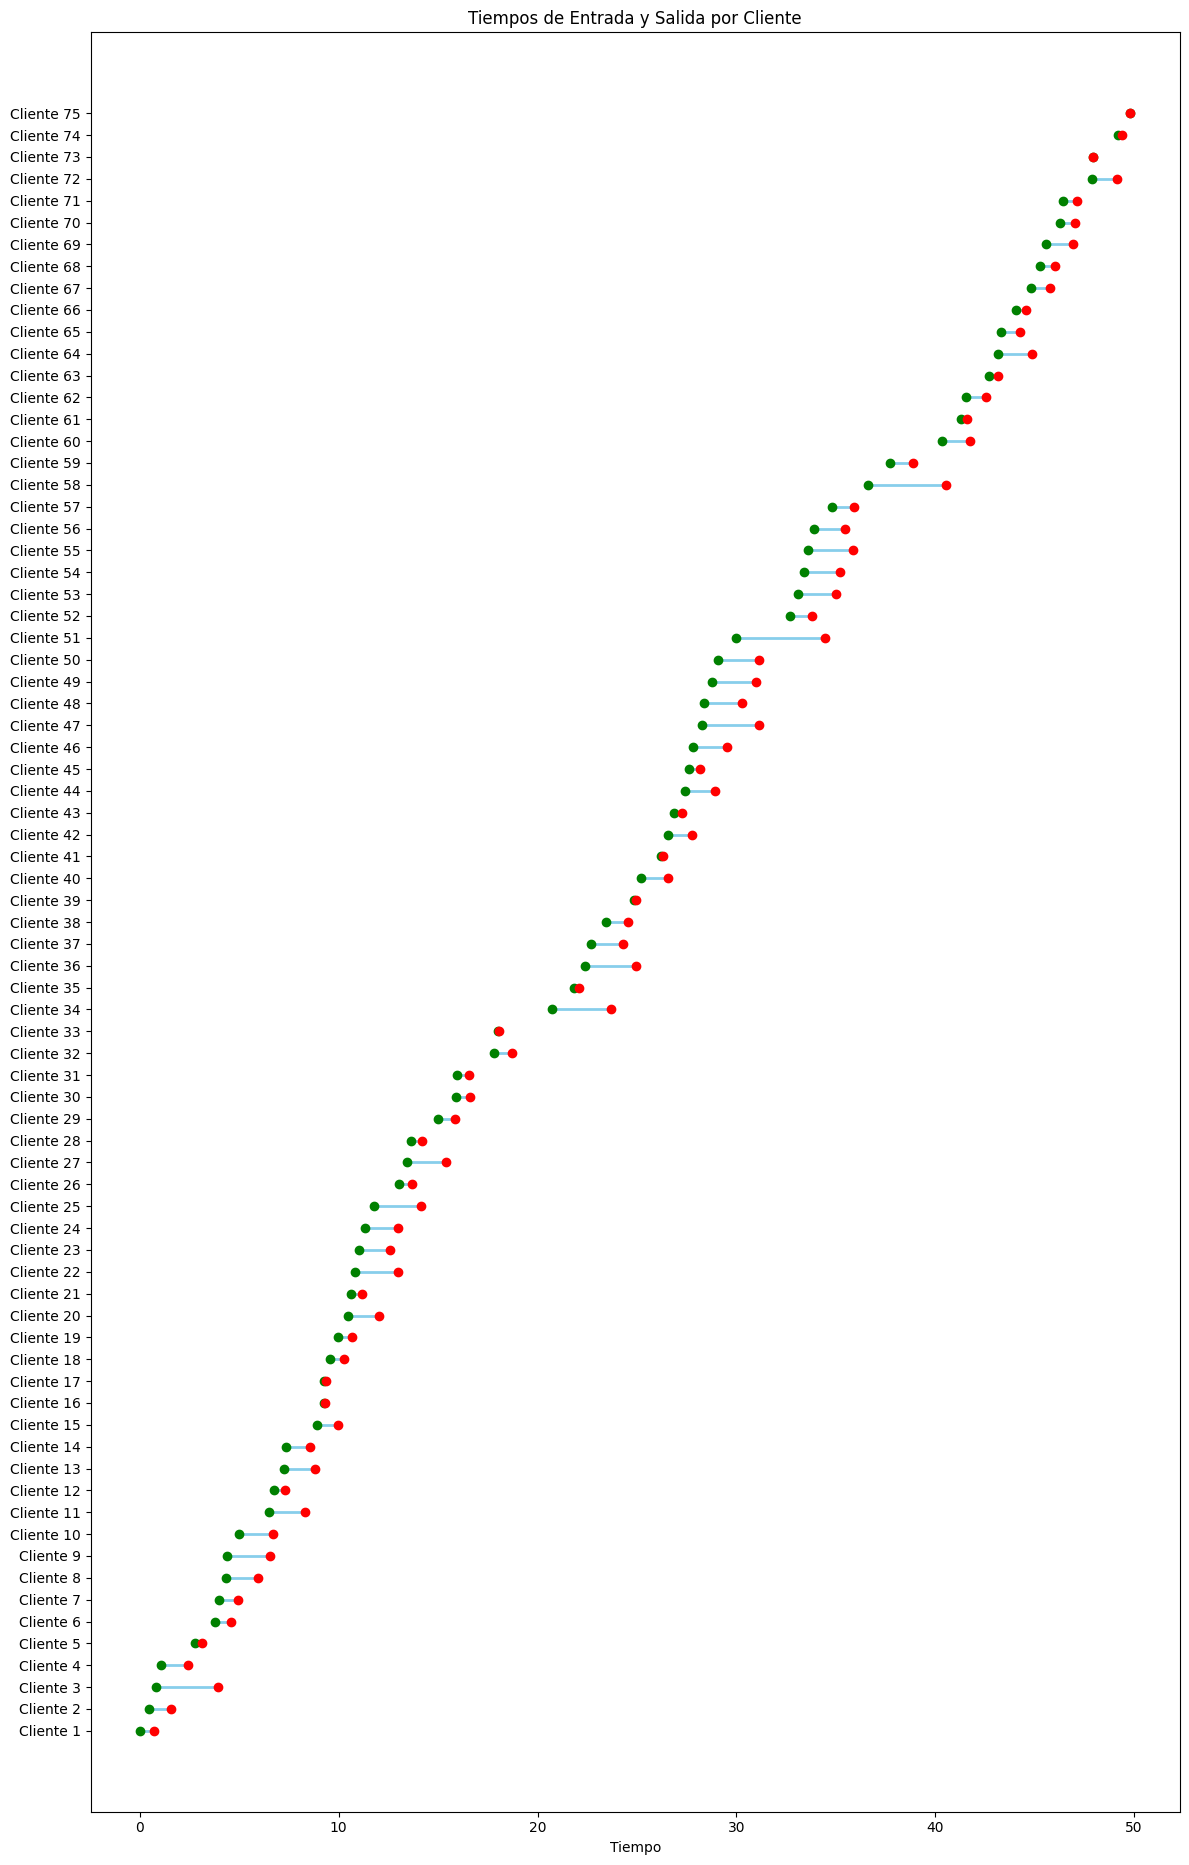

In [123]:
# --- TEST 9: Análisis del tiempo de entrada y salida en colas no congestionadas ---

_, _, _, _, arrival_times, departure_times, _ = simulate_queueing_system(
    servers_ammount=2,
    arrival_rate=1.5,
    service_time_rates=[1, 1],
    time_limit=50
)

clients = sorted(arrival_times.keys())
fig, ax = plt.subplots(figsize=(12, len(clients) * 0.25))

for idx, client_id in enumerate(clients):
    start = arrival_times[client_id]
    end = departure_times.get(client_id, start)  # por si no salió aún
    ax.hlines(y=idx, xmin=start, xmax=end, color='skyblue', linewidth=2)
    ax.plot(start, idx, 'go')  # punto de llegada
    ax.plot(end, idx, 'ro')    # punto de salida

ax.set_yticks(range(len(clients)))
ax.set_yticklabels([f"Cliente {c}" for c in clients])
ax.set_xlabel("Tiempo")
ax.set_title("Tiempos de Entrada y Salida por Cliente")
plt.tight_layout()
plt.show()

**CONCLUSIONES:** Podemos observar que muy pocos o ningún cliente dejó de ser atendido durante el tiempo de ejecución de la simulación, pues casi todos los clientes tienen un tiempo de entrada y salida del sistema. Aquellos que no tienen tiempo de salida son representados como un punto rojo en el gráfico.

**TEST 10:** Este test tiene como objetivo evaluar el comportamiento del tiempo de entrada y salida de los clientes en una cola congestionada.

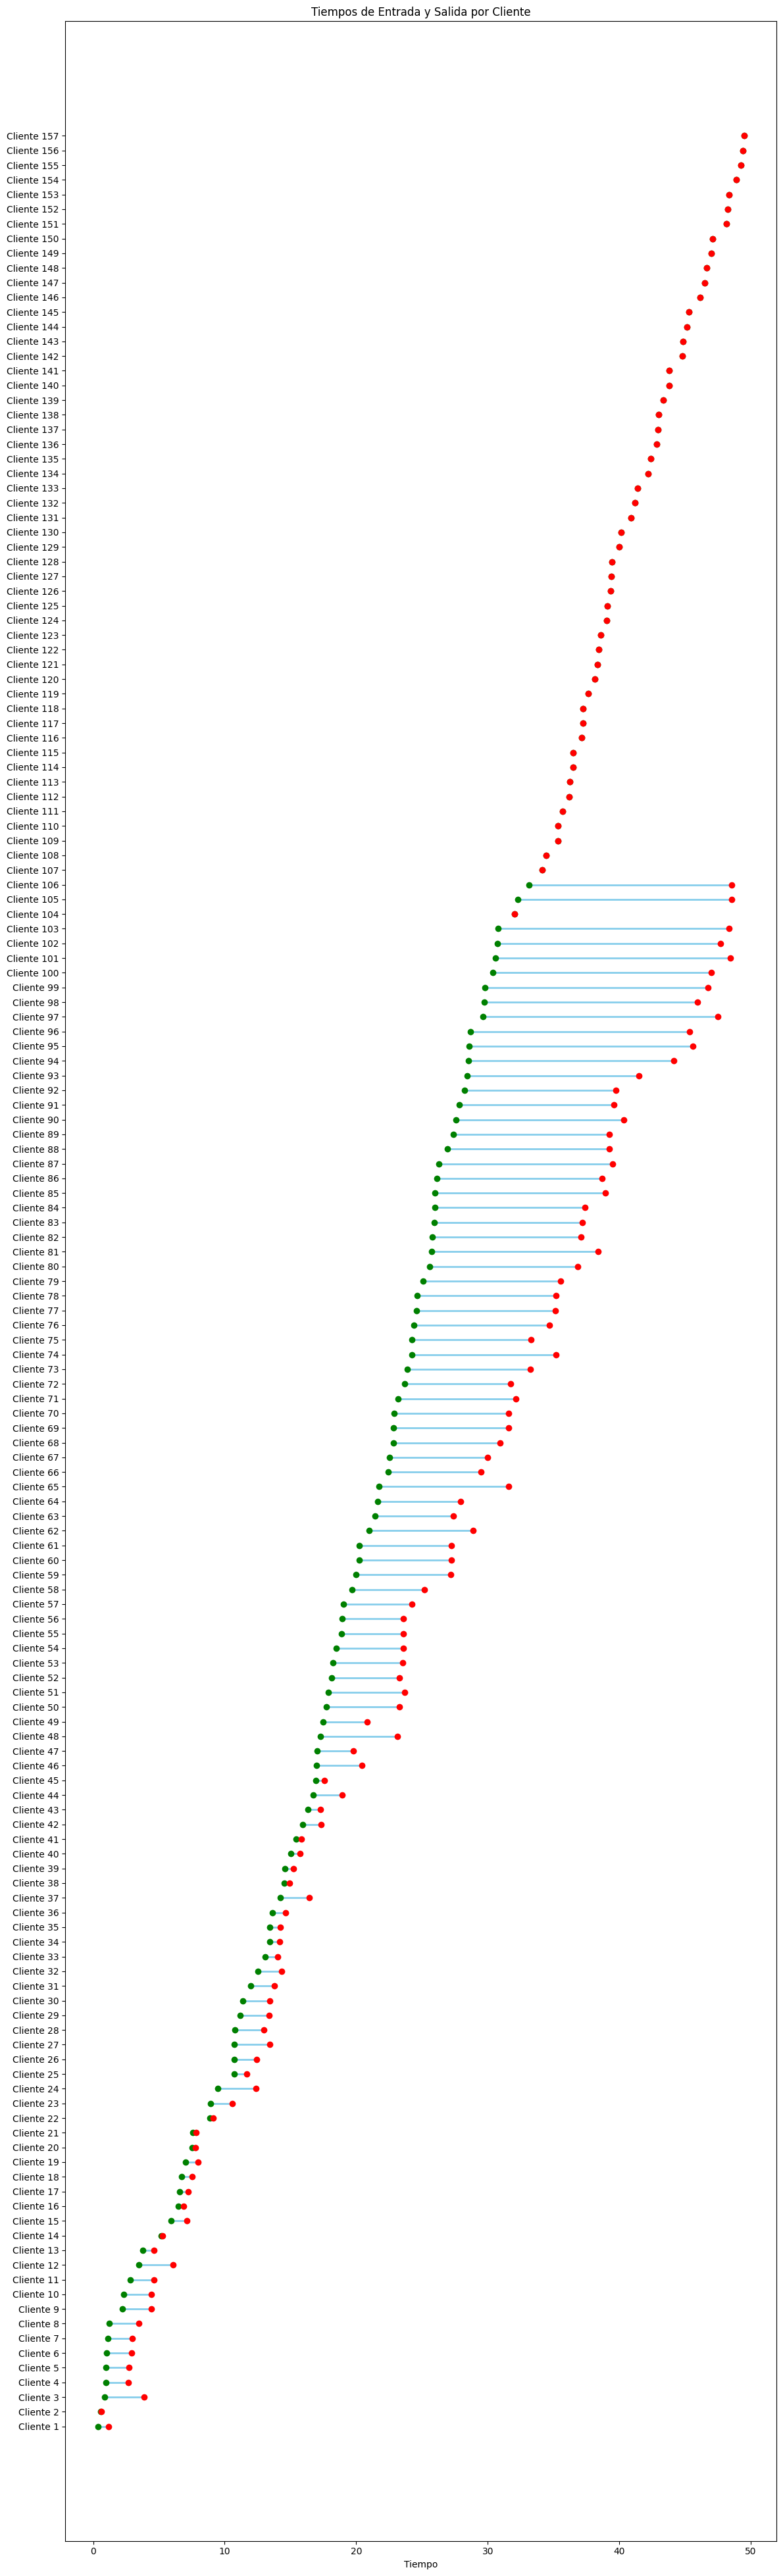

In [124]:
# --- TEST 10: Análisis del tiempo de entrada y salida en colas congestionadas ---

_, _, _, _, arrival_times, departure_times, _ = simulate_queueing_system(
    servers_ammount=2,
    arrival_rate=3,
    service_time_rates=[1, 1],
    time_limit=50
)

clients = sorted(arrival_times.keys())
fig, ax = plt.subplots(figsize=(12, len(clients) * 0.25))

for idx, client_id in enumerate(clients):
    start = arrival_times[client_id]
    end = departure_times.get(client_id, start)  # por si no salió aún
    ax.hlines(y=idx, xmin=start, xmax=end, color='skyblue', linewidth=2)
    ax.plot(start, idx, 'go')  # punto de llegada
    ax.plot(end, idx, 'ro')    # punto de salida

ax.set_yticks(range(len(clients)))
ax.set_yticklabels([f"Cliente {c}" for c in clients])
ax.set_xlabel("Tiempo")
ax.set_title("Tiempos de Entrada y Salida por Cliente")
plt.tight_layout()
plt.show()

**CONCLUSIONES:** Podemos observar que bastantes clientes dejaron de ser atendidos durante el tiempo de ejecución de la simulación. Esto se debe a que la cantidad de clientes generados antes de la finalización del tiempo fue superior a la cantidad de clientes que los servidores podían manejar en el mismo lapso de tiempo.

# PLAYGROUND

In [128]:
# --- PLAYGROUND --- (ESTA CELDA ES PARA PROBAR CÓDIGO)
average_system_times, average_standby_time, processing_time, server_percentages, arrival_times, departure_times, server_served_count = simulate_queueing_system(
    servers_ammount=3,
    arrival_rate=1,
    service_time_rates=[0.5, 1, 2],
    time_limit=3000
)
print("INSERTAR DATOS")


INSERTAR DATOS
